This notebook is heavily based on [this Colab notebook](https://colab.research.google.com/github/keras-team/keras-io/blob/master/guides/ipynb/keras_cv/object_detection_keras_cv.ipynb). It doesn't deploy the object detection model, it is only for ensuring the model creation steps and prediction are functioning.

In [5]:
import keras_cv
import tensorflow as tf
from adlc_util import visualize_dataset, visualize_detections
import tqdm

CLASS_MAPPING = {0:"target"}

Using TensorFlow backend


/home/abcoste2/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Hyperparameters

INPUT_SIZE_X = 640
INPUT_SIZE_Y = 640

BASE_LR = 0.005
N_EPOCHS = 1

### Load datasets from file

Load the datasets processed by `process_dataset.py`, which have already been split into train/test.

**NOTE:** this requires tensorflow>=2.14 on linux: https://github.com/XiaotingChen/maxatac_pip_1.0.5/issues/2

In [7]:
train_ds = tf.data.Dataset.load(path="../data/238_train_ds", compression="GZIP")
test_ds = tf.data.Dataset.load(path="../data/238_test_ds", compression="GZIP")

### Augment Data

This block creates new observations from the data by applying random transformations to the input images and resizing the images.

In [8]:
augmenter = tf.keras.Sequential(
    layers=[
        # Adding/changing layers will adjust transformations on original observations
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(INPUT_SIZE_X, INPUT_SIZE_Y),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xywh",
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Apply resize to test data
inference_resizing = keras_cv.layers.Resizing(
    INPUT_SIZE_X, INPUT_SIZE_Y, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
test_ds = test_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

Optionally, visualize a sample of the dataset after augmentation.

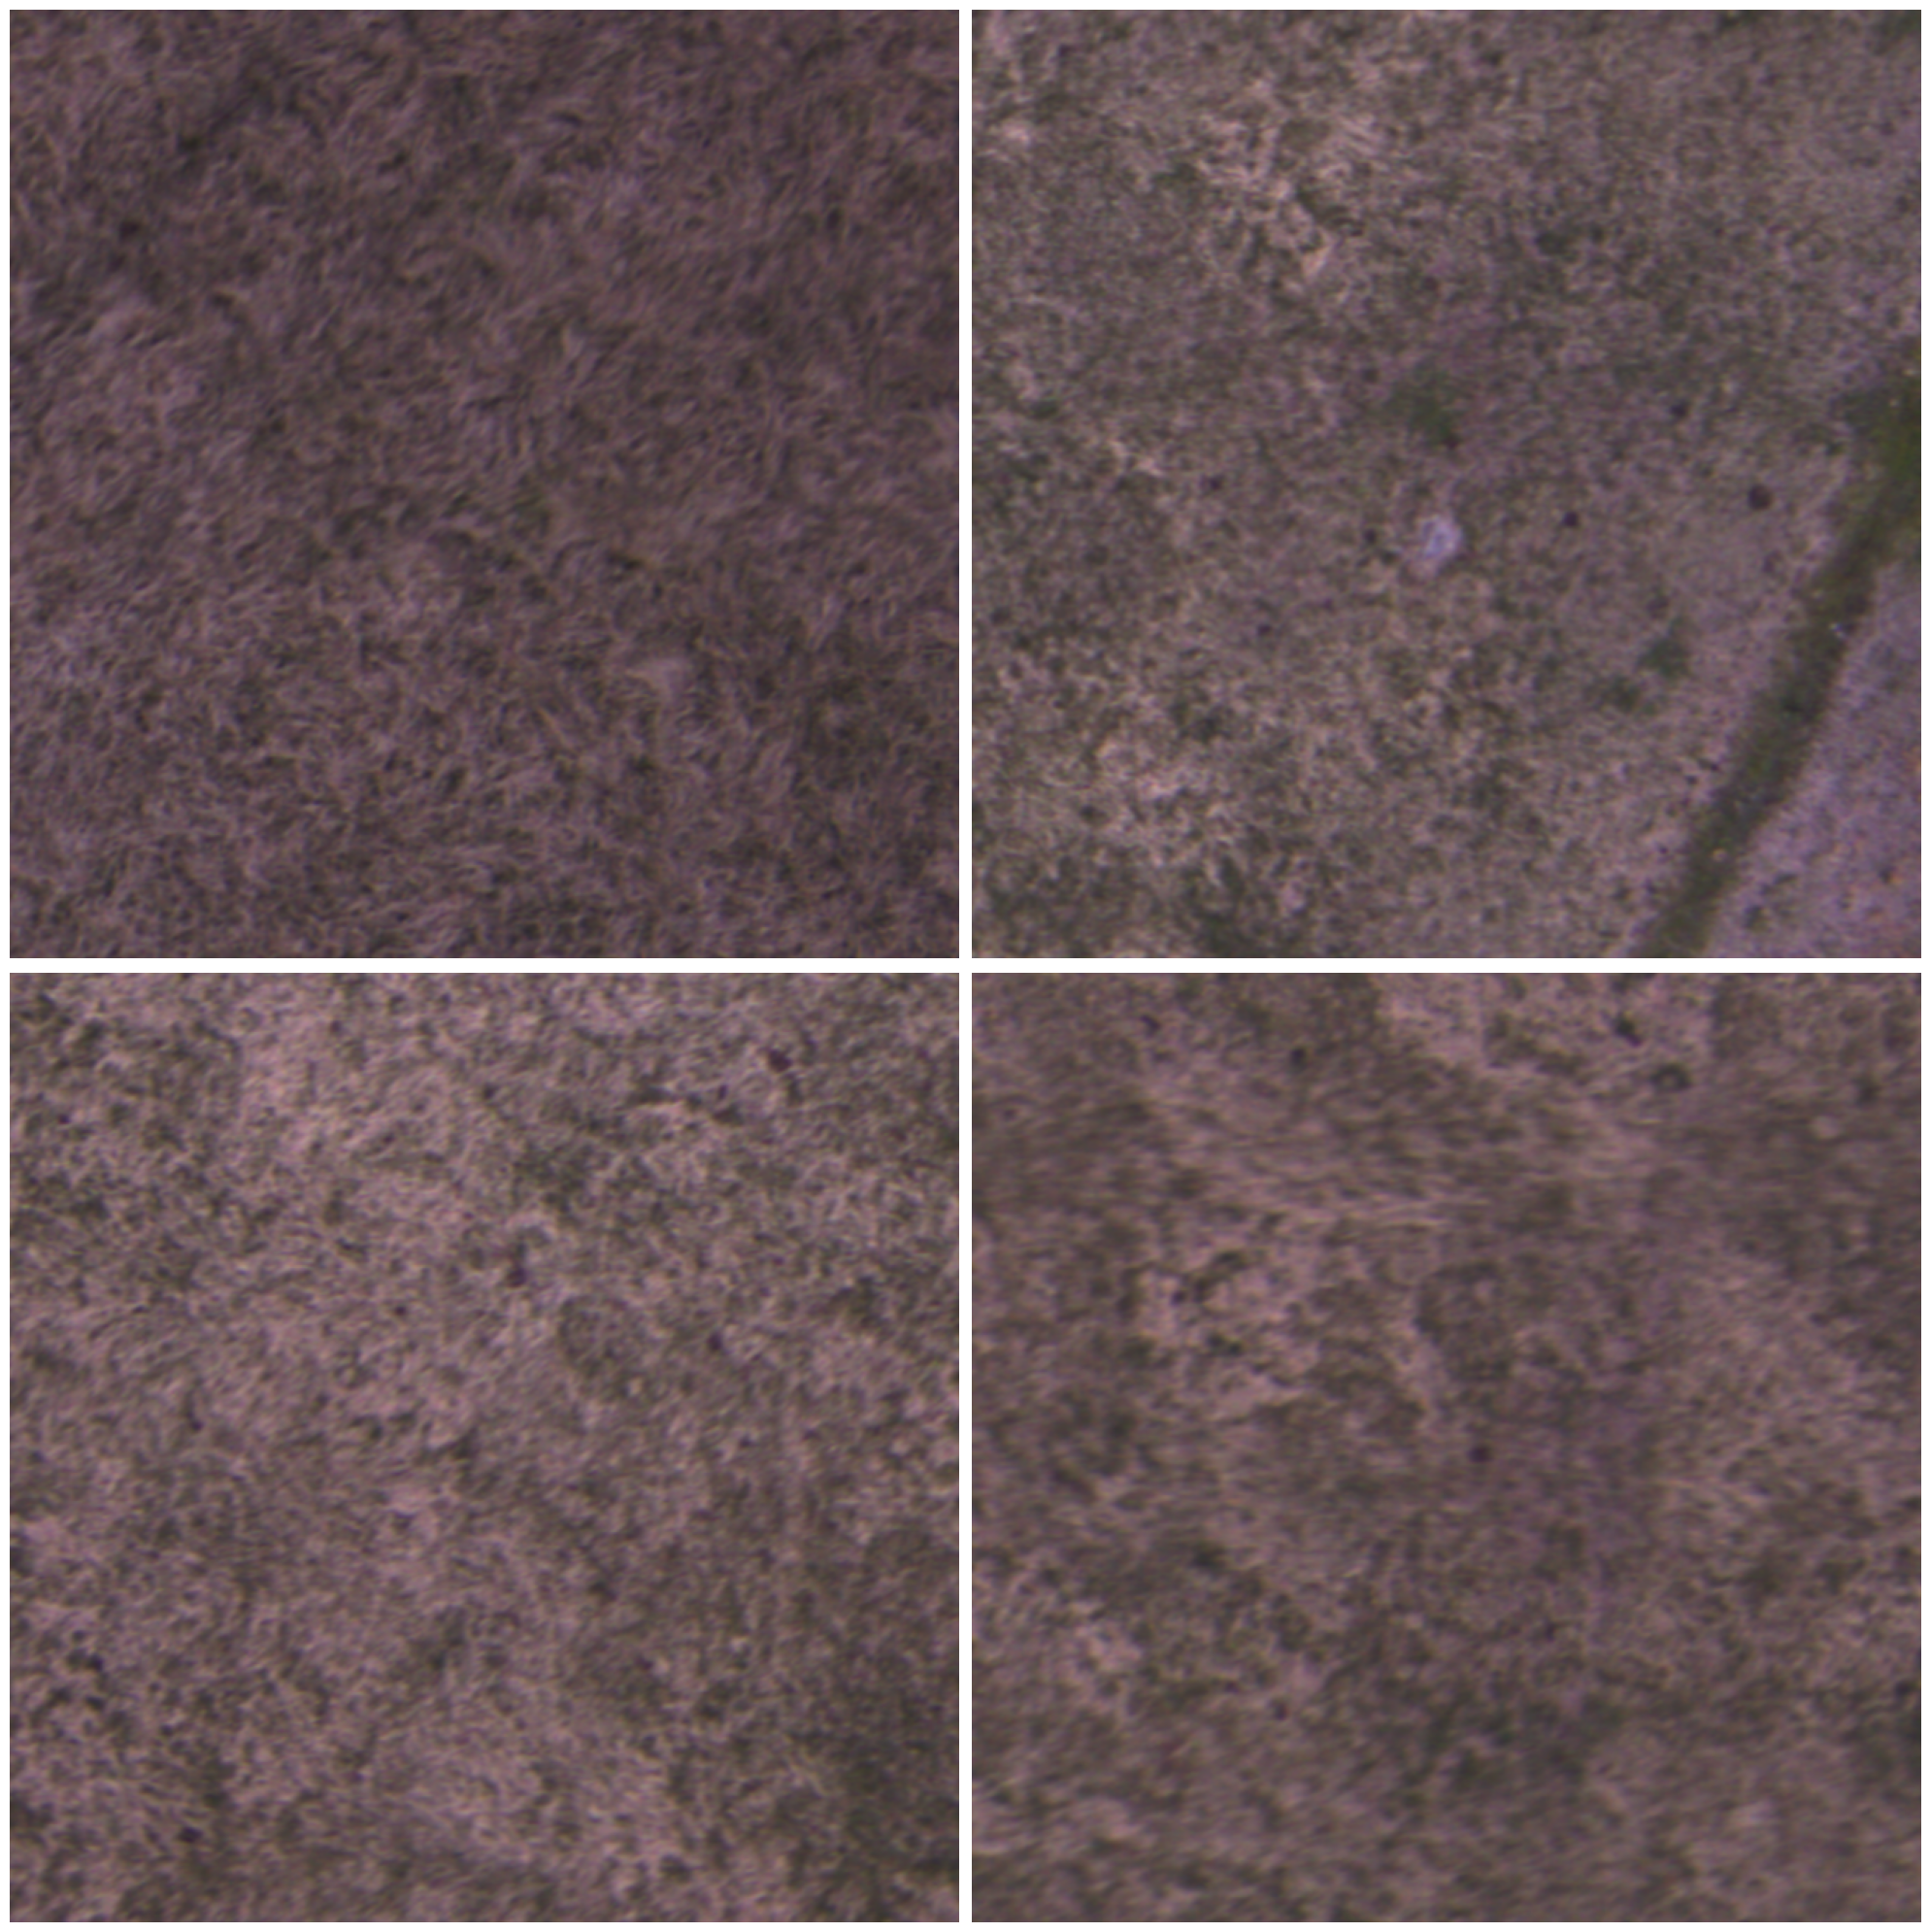

In [9]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2, offset=1
)

The following converts ragged bounding boxes to a format usable for training.

In [10]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

### Create Model

Initialize Optimizer

In [11]:
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=BASE_LR, momentum=0.9, global_clipnorm=10.0
)

Create RetinaNet with pre-trained weights

In [12]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(CLASS_MAPPING),
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
)

2023-12-22 23:35:42.664370: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Initialize a decoder that will transform model output into usable results.

In [13]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
model.prediction_decoder = prediction_decoder

Initialize metrics for callbacks using [COCO Detection Evaluation](https://cocodataset.org/#detection-eval)

In [14]:
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)

def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")


In [15]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    metrics=[coco_metrics],
)
coco_metrics.reset_state()
result = model.evaluate(test_ds.take(1), verbose=0)
result = coco_metrics.result(force=True)

print_metrics(result)

2023-12-22 23:35:52.234972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-22 23:35:52.434277: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Metrics:
----------------------------
MaP                         : 0.00
MaP@[IoU=50]                : 0.00
MaP@[IoU=75]                : 0.00
MaP@[area=small]            : 0.00
MaP@[area=medium]           : 0.00
MaP@[area=large]            : 0.00
Recall@[max_detections=1]   : 0.00
Recall@[max_detections=10]  : 0.00
Recall@[max_detections=100] : 0.00
Recall@[area=small]         : 0.00
Recall@[area=medium]        : 0.00
Recall@[area=large]         : 0.00


Training

In [16]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

In [17]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

Fit the model

In [18]:
model.fit(
    train_ds.take(20),
    validation_data=test_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=N_EPOCHS,
    callbacks=[EvaluateCOCOMetricsCallback(test_ds.take(20)), 
    # VisualizeDetections(test_ds.take(20)) # not sure how to pass the visualizations
    ],
)

2023-12-22 23:36:14.521705: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb84a8f0430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 23:36:14.521748: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-22 23:36:14.595508: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - ETA: 0s - loss: 0.3437 - box_loss: 0.1493 - classification_loss: 0.1944 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.9688      

100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

6/6 [==============================] - 30s 2s/step - loss: 0.3437 - box_loss: 0.1493 - classification_loss: 0.1944 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.9688 - val_loss: 0.0000e+00 - val_box_loss: 0.0000e+00 - val_classification_loss: 0.0000e+00 - val_MaP: 0.0000e+00 - val_MaP@[IoU=50]: 0.0000e+00 - val_MaP@[IoU=75]: 0.0000e+00 - val_MaP@[area=small]: 0.0000e+00 - val_MaP@[area=medium]: 0.0000e+00 - val_MaP@[area=large]: 0.0000e+00 - val_Recall@[max_detections=1]: 0.0000e+00 - val_Recall@[max_detections=10]: 0.0000e+00 - val_Recall@[max_detections=100]: 0.0000e+00 - val_Recall@[area=small]: 0.0000e+0

Select a subset of the dataset for visualizing predictions.

In [16]:
visualization_ds = test_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Visualize predictions on test data. Requires IPython / Jupyter

1/1 [==============================] - 0s 104ms/step


IndexError: index 2 is out of bounds for axis 0 with size 2

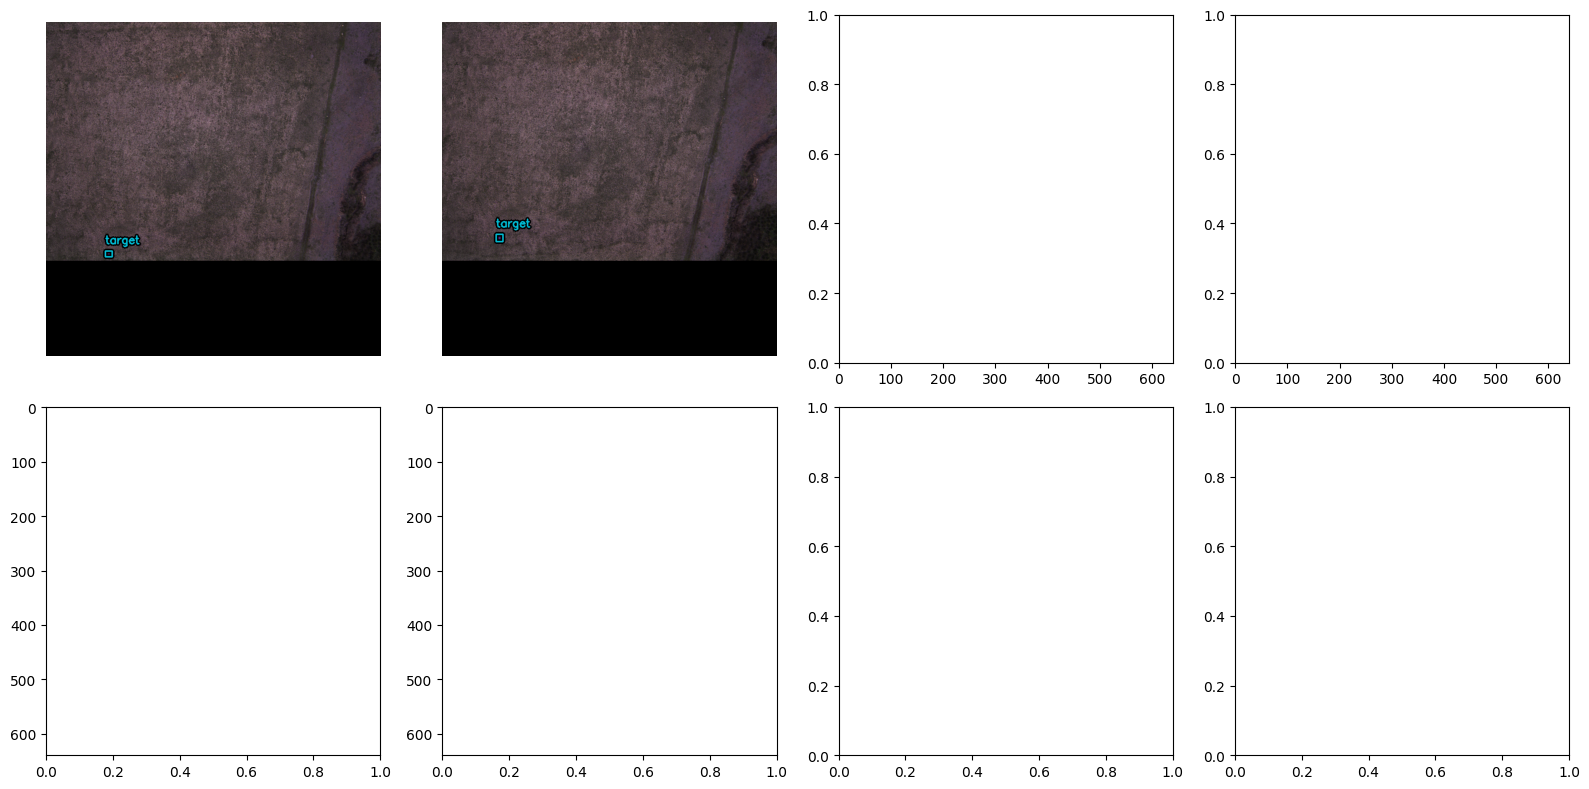

In [20]:
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

In [23]:
import time
model.save(f"adlc-detect_{time.time()}.keras")

In [30]:
from PIL import Image
import tensorflow as tf
from keras_preprocessing import image
import keras
import numpy as np

# images = [Image.open("../data/flight_238/flight_238_im32.jpg"), Image.open("../data/flight_238/flight_238_im33.jpg")]

images = np.array(keras.utils.load_img("../data/flight_238/flight_238_im32.jpg"))
# tensor_images = tf.data.Dataset.from_tensor_slices([[tf.convert_to_tensor(img)] for img in images])

# Make predictions and convert to ragged (variable length) tensors 
# encoded_predictions = model(images[0])
# y_pred = model.decode_predictions(encoded_predictions, images)
print( model.predict(np.array([images])))

1/1 [==============================] - 7s 7s/step
{'boxes': array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-